In [0]:
!rm -r *


#!head MicrobiotaGAN/discriminator.py

from google.colab import files


In [0]:
!wget https://www.dropbox.com/s/c94s64a00k7m39y/MicrobiotaGAN.zip   # https://www.dropbox.com/s/0r8hjgj72h1tfmb/MicrobiotaGAN.zip;
!unzip MicrobiotaGAN.zip;

# !wget https://www.dropbox.com/s/yqw6vqbvt8m1g5g/images_1000_dataset.pickle 

!wget https://www.dropbox.com/s/8c42zghpjwfuwdy/second_dataset.zip;
    
!unzip second_dataset.zip;
    
% ls

--2018-11-30 02:39:36--  https://www.dropbox.com/s/c94s64a00k7m39y/MicrobiotaGAN.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/c94s64a00k7m39y/MicrobiotaGAN.zip [following]
--2018-11-30 02:39:37--  https://www.dropbox.com/s/raw/c94s64a00k7m39y/MicrobiotaGAN.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceacec4a95305f63bd6e20a859b.dl.dropboxusercontent.com/cd/0/inline/AWjAoOn4rFkf0flAe44kB2s4981hxHrK7MDPN1NxZ1leFaUZwcP016QeY3sLjRpXcqWmV16hBdW12l_strcealsMvHt7nI2seZGhv1yOrQ6r24vFXY5CFPqlLd9ssnBc3nx-aye9R-RrBKENOWWOQK32dwJmxEWuR8y8wCa--UX8oMdKZ3nEUx3p5p84ShkD6u0/file [following]
--2018-11-30 02:39:37--  https://uceacec4a95305f63bd6e20a859b.dl.dropboxusercontent.com/cd/0/inline/AWjAoOn4rFkf0flAe44kB2s4981hxHrK7

In [0]:
import tensorflow as tf 
 

from MicrobiotaGAN.generator import Generator
from MicrobiotaGAN.discriminator import Discriminator

from MicrobiotaGAN.cost import wasserstein_generator_cost
from MicrobiotaGAN.cost import wasserstein_discriminator_cost

from MicrobiotaGAN.xavier_initialization import xavier_init
from MicrobiotaGAN.input_noise_sample import input_noise_sample

from MicrobiotaGAN.dataset_manager import DataSetManager
from MicrobiotaGAN.display_microbiota import display_microbiota

from MicrobiotaGAN.glv_loss import GLV_Model


from MicrobiotaGAN.utilities import *

In [0]:
import numpy as np
import pandas as pd


from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle
import os

import seaborn as sns

sns.set()
from timeit import default_timer as timer


In [0]:


microbiota_table = pd.read_csv('abundances.csv',header=None  ).values

 
    
param_path = 'image_dynamics_param.pickle' 

with open(param_path, 'rb') as pickleFile:
    microbiota_parameters = pickle.load(pickleFile)

# Splitting data into training set and test set

In [0]:
# Load Data to the data mangaer

np.random.shuffle(microbiota_table)

training_percent = 0.9

lim = int(np.ceil(microbiota_table.shape[0]*training_percent))
train_set = microbiota_table[0:lim,:]
test_set = microbiota_table[lim:,:]
print("Test set" +str(test_set.shape))
print("Train set: "+str(train_set.shape))


microbiota_test_set =  DataSetManager(test_set, norm=True)
microbiota_train_set=  DataSetManager(train_set, norm=True)


#Unrolls again
mbio_dict = ds_statistic_summary_dict(microbiota_table)
 

Test set(10000, 50)
Train set: (90000, 50)


In [0]:
np.std(mbio_dict["max_vec"], ddof=1)  

58.89077366191364

In [0]:
microbiota_parameters.keys()

dict_keys(['N', 'rho', 'sigma', 'mu', 'T_f', 'A', 'r'])

# Dataset exploration 

Sigma: 0.6
Rho: 0.1
Distance from origin: 0.6082762530298219


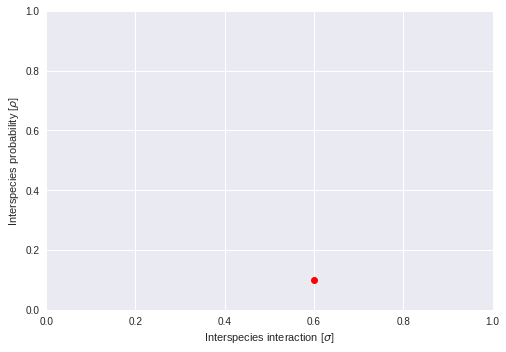

In [0]:
m_sigma = microbiota_parameters['sigma']
m_rho = microbiota_parameters['rho']
print("Sigma: "+str(m_sigma))
print("Rho: "+str(m_rho))

m_A = microbiota_parameters['A']

m_r = microbiota_parameters['r']

plt.axis(xmax=1, ymax=1)
plt.plot(m_sigma, m_rho,'ro')
 
plt.xlabel(r'Interspecies interaction [$\sigma$]') 
plt.ylabel(r'Interspecies probability [$\rho$]')

print("Distance from origin: "+ str(np.sqrt(m_rho**2 + m_sigma**2)))

Text(0.5,1,'A Matrix')

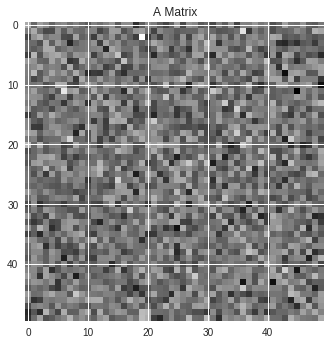

In [0]:
plt.imshow(microbiota_parameters['A'], cmap="gray_r")
plt.title("A Matrix")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


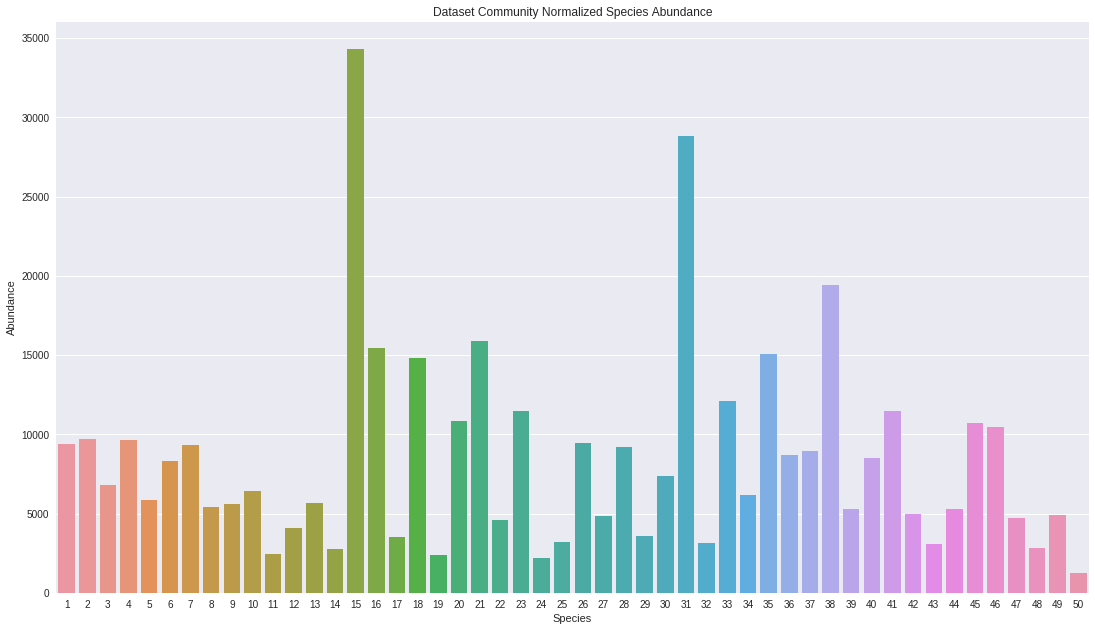

In [0]:
# Micorbiota abundance pseudo histogram
print(list(range(1,m_A.shape[0])))

sns.barplot(x = list(range(1,m_A.shape[0]+1)) ,y= np.sum(normalize_ds(microbiota_table), axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Computational Graph Definition

In [0]:
n_species : int = m_A.shape[0]
mini_batch_size : int =32

noise_dim : int = 10

# Computation Graph Definition
my_generator = Generator(noise_dim, n_species)
my_discriminator = Discriminator(n_species)

real_sample = tf.placeholder(tf.float32, shape=[None, n_species])
noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])

D_real, D_logit_real = my_discriminator.train_probability_and_logit(real_sample)



# Train Graph
generator_sample_train = my_generator.train_draw_samples(noise_sample)
D_fake_train, D_logit_fake_train = my_discriminator.train_probability_and_logit(generator_sample_train)

D_cost_train =  wasserstein_discriminator_cost(D_logit_real, D_logit_fake_train)
G_cost_train = wasserstein_generator_cost( D_logit_fake_train)

D_solver_train = my_discriminator.optimize_step(D_cost_train)
G_solver_train = my_generator.optimize_step(G_cost_train)

# Inference Graph
generator_sample_inference = my_generator.inference_draw_samples(noise_sample)
D_fake_inference, D_logit_fake_inference = my_discriminator.inference_probability_and_logit(generator_sample_inference)


D_cost_inference =  wasserstein_discriminator_cost(D_logit_real, D_logit_fake_inference)
G_cost_inference = wasserstein_generator_cost( D_logit_fake_inference)

D_solver_inference = my_discriminator.optimize_step(D_cost_inference)
G_solver_inference = my_generator.optimize_step(G_cost_inference)

# Others
clip_D = my_discriminator.clip_parameters(0.01)


In [0]:
# Initialize the network graph
# sess = tf.InteractiveSession() # tf.Session()
# sess.run(tf.global_variables_initializer())

#Train Loop


In [0]:

number_of_fig_per_plot :int = 16
#Training Loop
counter = 0
d_iter_ratio: int = 5

train_epochs = 20

iters_per_epoch = train_set.shape[0]//mini_batch_size


numero_de_iteraciones =   train_epochs*iters_per_epoch
# Since the discriminator is trained 5 times more, de divide the number of iterations
numero_de_iteraciones = int(np.ceil(numero_de_iteraciones/d_iter_ratio))

start = timer()

train_g_cost_record = []
train_d_cost_record = []
iter_record_g = []
iter_record_d = []

epoch_record_g = []
epoch = []

g_train_epoch_cost = []
d_train_epoch_cost =[]
 

initial_epochs = microbiota_train_set._epochs_completed    

little_record = [ ]

#### Sess 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


    it = 0


    while microbiota_train_set._epochs_completed - initial_epochs <   train_epochs:

        it += 1
        
        if microbiota_train_set._epochs_completed ==2:
            little_record.append(sess.run(my_generator.G_W1))

        # Train more the discrimantor    
        for k in range(d_iter_ratio):      


            #f k%5 == 0 and k != 0:
                #pass
            previous_epoch = microbiota_train_set._epochs_completed        
            real_sample_mini_batch = microbiota_train_set.next_batch(mini_batch_size)
            current_epoch = microbiota_train_set._epochs_completed


            dis_var_dict = {real_sample: real_sample_mini_batch, noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
            _, D_current_cost, _ = sess.run([D_solver_train, D_cost_train, clip_D], feed_dict=dis_var_dict)
            train_d_cost_record.append(D_current_cost)
            iter_record_d.append(it+1+k)



            if current_epoch > previous_epoch :
                d_train_epoch_cost.append(D_current_cost)
                g_train_epoch_cost.append(G_current_cost)    

        # End For



        # Apply the optimization algorithm and update both newtwork parameters
        gen_var_dict = {noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
        _, G_current_cost = sess.run([G_solver_train, G_cost_train], feed_dict=gen_var_dict)    
        train_g_cost_record.append(G_current_cost)

        iter_record_g.append(it)
        """
        if it%iters_per_epoch == 0 and (k !=0):
        g_train_epoch_cost.append(G_current_cost)    
        """


        if it % (numero_de_iteraciones//10) == 0 or it==0:
            end = timer()
            print("Progreso :"+str(100*it/(1.0*numero_de_iteraciones))+" %")
            print(str(end - start)+" s")

            print("Epochs completed so far "+str(microbiota_train_set._epochs_completed))

            print('\t Iter: {}'.format(it))
            print('\t D loss: {:.4}'.format(D_current_cost))
            print('\t G_loss: {:.4}'.format(G_current_cost))


    saver = tf.train.Saver()
    saver.save(sess, '/content/trained_gan.ckpt')
    little_record.append(sess.run(my_generator.G_W1))

Progreso :9.992887624466572 %
12.109637417997874 s
Epochs completed so far 1
	 Iter: 1124
	 D loss: 0.0
	 G_loss: -1.0
Progreso :19.985775248933145 %
23.594597446997795 s
Epochs completed so far 3
	 Iter: 2248
	 D loss: 0.0
	 G_loss: -1.0
Progreso :29.978662873399717 %
35.6303519159992 s
Epochs completed so far 5
	 Iter: 3372
	 D loss: 0.0
	 G_loss: -1.0


KeyboardInterrupt: ignored

In [0]:
print(np.sum(little_record[0]))
print(np.sum(little_record[1]))

In [0]:
#plt.plot(iter_record_g, g_cost_record)

In [0]:
#plt.plot(iter_record_d, d_cost_record)

# Test loop


In [0]:
   

number_of_fig_per_plot :int = 16
#Training Loop
counter = 0

test_epochs = train_epochs

iters_per_epoch = test_set.shape[0]//mini_batch_size

test_iter =   test_epochs*iters_per_epoch



#test_iter =  (numero_de_iteraciones*test_set.shape[0])//train_set.shape[0]

start = timer()

test_g_cost_record = []
test_d_cost_record = []
iter_test_record_g = []
iter_test_record_d = []

 
g_test_epoch_cost = []
d_test_epoch_cost =[]
 

epoch_record_g = []
epoch = []

d_iter_ratio: int = 5
    
print(iters_per_epoch)
print(test_iter)
print(test_set.shape[0])


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/content/trained_gan.ckpt')

    for it in range(test_iter):

        # Train more the discrimantor    
        for k in range(d_iter_ratio):      

            #f k%5 == 0 and k != 0:
                #pass

            real_sample_mini_batch = microbiota_test_set.next_batch(mini_batch_size)
            dis_var_dict = {real_sample: real_sample_mini_batch, noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
            D_current_test_cost, _ = sess.run([ D_cost_inference, clip_D], feed_dict=dis_var_dict)
            test_d_cost_record.append(D_current_test_cost)
            iter_test_record_d.append(it+1+k)





        # End For



        # Apply the optimization algorithm and update both newtwork parameters
        gen_var_dict = {noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
        temp_g_cost = sess.run([ G_cost_inference], feed_dict=gen_var_dict)
        #Since is the single fetch
        G_current_test_cost = temp_g_cost[0]

        test_g_cost_record.append(G_current_test_cost)

        iter_test_record_g.append(it)

        if it%iters_per_epoch == 0 and (k !=0):
            d_test_epoch_cost.append(D_current_test_cost)
            g_test_epoch_cost.append(G_current_test_cost)

        if it % (test_iter//10) == 0:
            end = timer()
            print("Progreso :"+str(100*it/(1.0*test_iter))+" %")
            print(str(end - start)+" s")

            print("epochs completed "+str(microbiota_test_set._epochs_completed))
            print(it/(iters_per_epoch/5))


            print('\t Iter: {}'.format(it))
            print('\t D loss: {:.4}'.format(D_current_test_cost))
            print('\t G_loss: {:.4}'.format(G_current_test_cost))


312
31200
10000
INFO:tensorflow:Restoring parameters from /content/trained_gan.ckpt
Progreso :0.0 %
0.2757586240004457 s
epochs completed 0
0.0
	 Iter: 0
	 D loss: 0.0
	 G_loss: -1.0
Progreso :10.0 %
17.34831228999974 s
epochs completed 49
50.0
	 Iter: 3120
	 D loss: 0.0
	 G_loss: -1.0
Progreso :20.0 %
34.32246119100091 s
epochs completed 99
100.0
	 Iter: 6240
	 D loss: 0.0
	 G_loss: -1.0
Progreso :30.0 %
52.18804214999909 s
epochs completed 149
150.0
	 Iter: 9360
	 D loss: 0.0
	 G_loss: -1.0
Progreso :40.0 %
69.23512645400115 s
epochs completed 199
200.0
	 Iter: 12480
	 D loss: 0.0
	 G_loss: -1.0
Progreso :50.0 %
86.18912314300178 s
epochs completed 249
250.0
	 Iter: 15600
	 D loss: 0.0
	 G_loss: -1.0
Progreso :60.0 %
103.12789797300138 s
epochs completed 299
300.0
	 Iter: 18720
	 D loss: 0.0
	 G_loss: -1.0
Progreso :70.0 %
121.55896478000068 s
epochs completed 349
350.0
	 Iter: 21840
	 D loss: 0.0
	 G_loss: -1.0
Progreso :80.0 %
138.56637119199877 s
epochs completed 399
400.0
	 Iter:

FailedPreconditionError: ignored

# Generator Loss Graph

In [0]:
iter_line = list(range(len(train_g_cost_record)))
test_iter_line = list(range(len(test_g_cost_record)))

epochs_list = list(range(len(g_test_epoch_cost)))


#plt.plot(iter_line, train_g_cost_record )
#plt.plot(test_iter_line, test_g_cost_record)

plt.plot(epochs_list, g_train_epoch_cost)

plt.plot(epochs_list, g_test_epoch_cost)

plt.legend(['train set', 'test set'], loc='upper right')
plt.title("Generator Loss")

plt.xlabel("epochs")
plt.ylabel("Loss")

#train_g_cost_record

In [0]:
plt.plot(epochs_list, d_train_epoch_cost)

plt.plot(epochs_list, d_test_epoch_cost)

## Closer look on the interval [0,100]

In [0]:
plt.title("Generator loss on test set")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iter_line[0:100],test_g_cost_record[0:100])


# Discriminator Loss Graph

In [0]:
iter_line_d = list(range(len(train_d_cost_record)))

#plt.plot(iter_line_d,train_d_cost_record )
#plt.plot(iter_line_d,test_d_cost_record)


plt.plot(epochs_list, d_train_epoch_cost)

plt.plot(epochs_list, d_test_epoch_cost)


plt.legend(['train set', 'test set'], loc='upper right')
plt.title("Discriminator Loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")

#train_g_cost_record

## Closer look on the interval [0,100]

In [0]:
plt.title("Discriminator loss on test set")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iter_line_d[0:100],test_d_cost_record[0:100])


# Saving the model and othe file management

In [0]:

#Comprimimos todos los archivos que se regenraron al guardar el moelo y despues lo descargamos
!zip  bio_gan.zip bio_gan.*

files.download("bio_gan.zip")

In [0]:
!ls

In [0]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/content/trained_gan.ckpt')
    
    w1 = sess.run(my_generator.G_W1)
    b1 = sess.run(my_generator.G_b1)

    w2= sess.run(my_generator.G_W2)
    b2 = sess.run(my_generator.G_b2)



gen_weights_and_bias = [w1, b1, w2, b2]

print(w1)

In [0]:
#import pickle

In [0]:
with open('gen_param.pkl', 'wb') as f:
  pickle.dump(gen_weights_and_bias, f)

# Using the Generator to create some samples

In [0]:
# generator_sample_inference = my_generator.inference_draw_samples(noise_sample)

noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])
sample_nara = my_generator.inference_draw_samples(noise_sample)

    
n_samples = 10
samples_table = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess, '/content/trained_gan.ckpt')

    for k in range(n_samples):
        
        magico = input_noise_sample(1, 10)
        print(np.sum(magico))

        
        f_sam = sess.run(sample_nara, feed_dict={noise_sample :magico})
        samples_table.append(f_sam[0] )
        done_per =(k/(1.0*n_samples))*100
        #print(str(round(done_per,2))+"% has samples have been created")
        #print(k)
        if k%(n_samples//10)==0:
            print(str(done_per)+"% has samples have been created")

samples_table = np.array(samples_table)

INFO:tensorflow:Restoring parameters from /content/trained_gan.ckpt
1.9858812
0.0% has samples have been created
1.0832623
10.0% has samples have been created
0.2595018
20.0% has samples have been created
-1.08285
30.0% has samples have been created
-0.43566033
40.0% has samples have been created
-1.0620242
50.0% has samples have been created
1.1318662
60.0% has samples have been created
-3.734453
70.0% has samples have been created
-0.046339855
80.0% has samples have been created
-0.4751354
90.0% has samples have been created


In [0]:
sumatorias = [ np.sum(samples_table[k,:]) for k in range(samples_table.shape[0])]

prome = [ np.mean(samples_table[k,:]) for k in range(samples_table.shape[0])]
print(sumatorias[0:5])
print(prome[0:5])
print(len(prome))

[36.552933, 36.552933, 36.552933, 36.552933, 36.552933]
[0.73105866, 0.73105866, 0.73105866, 0.73105866, 0.73105866]
10


In [0]:
samples_table = np.array(samples_table) 
    
    
ts_min = []
for row in range(samples_table.shape[0]):
    ts_min.append(np.min(samples_table[row,:]))
    
ts_max = []
for row in range(samples_table.shape[0]):
    ts_max.append(np.max(samples_table[row,:]))
    
ts_max = np.array(ts_max)
ts_min = np.array(ts_min)
    
new_samples_table =  []
for row in range(samples_table.shape[0]):

    _ = samples_table[row,:]*(ts_max[row]-ts_min[row])+ts_min[row]
    new_samples_table.append(_)
      
new_samples_table = np.array(new_samples_table)

 

glv_gen_errors = []
for k in range(samples_table.shape[0]):
    error = np.sum( GLV_Model(samples_table[k,:], m_A, m_r ))
    #print(error)
    glv_gen_errors.append(error)
    
glv_gen_errors = np.array(glv_gen_errors)

 

In [0]:
print("GAN Samples: "+str(samples_table.shape[0]))
print("GAN mean GLV error : "+str(np.mean(glv_gen_errors)))
print("GAN GLV error std : "+str(np.std(glv_gen_errors)))

GAN Samples: 10
GAN mean GLV error : 27.05333153046494
GAN GLV error std : 0.0


In [0]:
sub = DataSetManager(train_set)

In [0]:
sub_train_set = sub.next_batch(samples_table.shape[0]) #train_set[0:n_samples,:]

glv_train_errors = []
for k in range(sub_train_set.shape[0]):
    error = np.sum( GLV_Model(sub_train_set[k,:], m_A, m_r ))
    #print(error)
    glv_train_errors.append(error)
    
glv_train_errors = np.array(glv_train_errors)

glv_mean_e = np.round(np.mean(glv_train_errors),4)
glv_e_std = np.round(np.std(glv_train_errors),4)


print("Training Samples <Normalized>: "+str(samples_table.shape[0]))
print("Sub Train Set mean GLV error : "+str(glv_mean_e))
print("Sub Train Set error std : "+str(glv_e_std))

Training Samples <Normalized>: 10
Sub Train Set mean GLV error : 0.0001
Sub Train Set error std : 0.0002


In [0]:
diff_e = np.mean(glv_gen_errors)  - glv_mean_e 
diff_std = np.std(glv_gen_errors) - glv_e_std

print("Samples: "+str(samples_table.shape[0]))

print("GAN-Train mean GLV error : "+str(diff_e))
print("GAN-Train GLV error std : "+str(diff_std))

print("% GAN-Train mean GLV error : "+str(100*diff_e/glv_mean_e))
print("% GAN-Train GLV error std : "+str(100*diff_std/glv_e_std))


Samples: 10
GAN-Train mean GLV error : 27.05323153046494
GAN-Train GLV error std : -0.0002
% GAN-Train mean GLV error : 27053231.53046494
% GAN-Train GLV error std : -100.0


In [0]:
np.sum(samples_table < 0)

0

In [0]:
import pandas as pd

df = pd.DataFrame(samples_table)
with open('unormed.csv', 'a') as f:
    df.to_csv(f, header=False, index=False)
    
    

df = pd.DataFrame(new_samples_table)
with open('normalized.csv', 'a') as f:
    df.to_csv(f, header=False, index=False)    
    
!zip gan_samples.zip *.csv

files.download("gan_samples.zip")

  adding: abundances.csv (deflated 69%)
  adding: normalized.csv (deflated 99%)
  adding: unormed.csv (deflated 99%)


## Asessing the GLV error

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


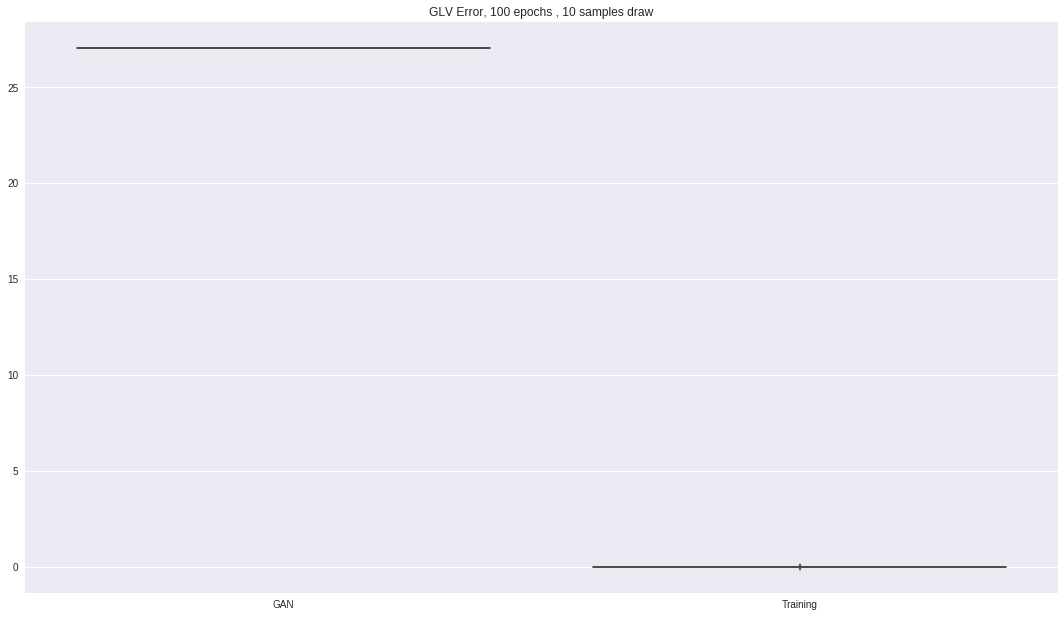

In [0]:
d = {'GAN': glv_gen_errors, 'Training': glv_train_errors }
df = pd.DataFrame(data=d)

ax = sns.boxplot( data=df)

plt.title("GLV Error, "+str(train_epochs)+" epochs , "+str(n_samples)+" samples draw")


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.savefig("glv_barplot.png")


In [0]:
# !rm *.png
files.download("glv_barplot.png")

# Misc

In [0]:
sns.barplot(x = list(range(1,51)) ,y= np.sum(normalize_ds(samples_table), axis=0))
plt.title("GAN-Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("fake.svg")

In [0]:

rnd_index = np.random.randint(low=1, high=140000,size=100)
sub_ds = normalize_ds(microbiota_table)[rnd_index]

sns.barplot(x = list(range(1,29)) ,y= np.sum(sub_ds, axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("real.svg")
 

In [0]:
files.download("real.svg")
files.download("fake.svg")

In [0]:
a_t = normalize_ds(samples_table)

In [0]:
show_rounded_array(a_t[8,:],2)

In [0]:
!zip  pics.zip *.svg
files.download("pics.zip")

In [0]:
!head -n 20 MicrobiotaGAN/generator.py

In [0]:
bool(1)

In [0]:
dir(my_generator)

In [0]:
def Diagonal_Matrix(input_vector):
     return np.multiply(np.identity(input_vector.shape[0]),input_vector)


In [0]:
s_0 = normalize_ds(microbiota_table)[0]

res = np.multiply(Diagonal_Matrix(s_0), np.matmul(m_A,s_0)+m_rho)

print(res[0,:])

plt.imshow(res, cmap="gray")


"""
print(m_A.shape)
print(s_0.shape)
print(s_0)
"""


In [0]:
!head -n 25 MicrobiotaGAN/glv_loss.py